In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plot for regression

In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.501763,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,1.462978,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.806580,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.583543,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.621663,1.001447,0.263620


Refer to [Gaussian process regression (GPR) with noise-level estimation](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html)  
with alpha only: predict different values for the same sequence  
with WhiteKernel: predict same values for the same sequence

X train shape:  (845, 20)
X test shape:  (210, 20)
create kernel instance
finish creating kernel instance
<function mean_squared_error at 0x7f13c5243b70>
Train:  0.23393637014110585
Test:  0.6650957150628526
<function r2_score at 0x7f13c5243d90>
Train:  0.7779907332407836
Test:  0.07235050899116813


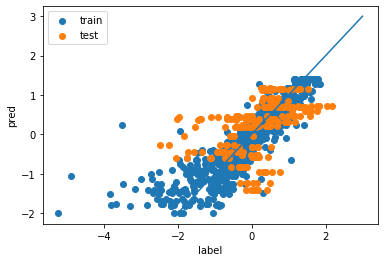

In [3]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 0, alpha = 0.0, eva_on='samples')
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

In [4]:
gpr_train_samples.gp_reg.kernel_

WD_Shift_Kernel(sigma_0=1e-10) + WhiteKernel(noise_level=0.273)

In [5]:
gpr_train_samples.train_df


,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,1.403222,0.558853
1,ATTAAGAAGGAGATATACAT,AGGAGA,1.338765,0.097386,bps_noncore,Rep1,1.221264,1.282292,0.558853
2,TCTAAGAAGGAGATATACAT,AGGAGA,1.382669,0.210012,bps_noncore,Rep1,1.160566,1.402521,0.559910
3,TATAAGAAGGAGATATACAT,AGGAGA,0.982789,0.120068,bps_noncore,Rep1,1.003687,1.078205,0.559910
4,TTGAAGAAGGAGATATACAT,AGGAGA,1.382763,0.201720,bps_noncore,Rep1,1.138820,1.406075,0.566727
...,...,...,...,...,...,...,...,...,...
841,TTTAAGATAAGGGTATACAT,TAAGGG,0.564876,0.143604,prob random,Rep6,0.432208,0.437835,0.557719
842,TTTAAGATAGTCTTATACAT,TAGTCT,0.585487,0.184425,prob random,Rep6,0.260032,0.429869,0.560540
843,TTTAAGAAAGTAGTATACAT,AAGTAG,0.380490,0.159538,prob random,Rep6,-0.182145,0.243456,0.560097
844,TTTAAGAGTAATGTATACAT,GTAATG,0.244736,0.169817,prob random,Rep6,-0.036484,0.037359,0.560130


In [6]:
gpr_train_samples.train_df[gpr_train_samples.train_df['RBS'] == 'CTTAAGAAGGAGATATACAT']

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,1.403222,0.558853
141,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep2,1.337018,1.403222,0.558853
282,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep3,1.417248,1.403222,0.558853
423,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep4,1.493800,1.403222,0.558853
564,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep5,1.713526,1.403222,0.558853
705,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep6,1.644568,1.403222,0.558853


In [7]:
gpr_train_samples.test_df[gpr_train_samples.test_df['RBS'] == 'TTTAAGATAAGATTATACAT']

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep1,-0.440723,0.393663,0.694287
35,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep2,-1.407786,0.393663,0.694287
70,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep3,-1.373892,0.393663,0.694287
105,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep4,-2.035393,0.393663,0.694287
140,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep5,-0.553289,0.393663,0.694287
175,TTTAAGATAAGATTATACAT,TAAGAT,-1.162217,0.663116,bandit,Rep6,-0.662509,0.393663,0.694287


In [8]:
wd_kernel =  WD_Shift_Kernel(l = 6, features = gpr_train_samples.features, s = 1)
#kernel_matrix_samples = wd_kernel.cal_kernel(np.asarray(gpr_train_samples.train_df['RBS']), np.asarray(gpr_train_samples.train_df['RBS']))
#np.linalg.eig(kernel_matrix)
kernel_matrix_samples = wd_kernel.kernel_all

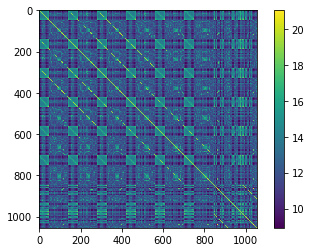

In [9]:
plt.imshow(kernel_matrix_samples)
plt.colorbar()

In [10]:
kernel_matrix_samples[0].all() == kernel_matrix_samples[141].all()

True

In [11]:
np.linalg.eigh(kernel_matrix_samples)

(array([-1.57486840e-12, -1.19663505e-12, -5.18292078e-13, ...,
         4.64816728e+02,  1.30417013e+03,  1.30511213e+04]),
 array([[ 0.00000000e+00,  5.07522622e-15,  0.00000000e+00, ...,
         -6.34645622e-04,  4.90272030e-02,  3.24831102e-02],
        [ 3.05233767e-01, -8.17120491e-01,  1.36850867e-02, ...,
         -6.34650703e-04,  4.90272218e-02,  3.24831103e-02],
        [ 1.81392158e-01, -1.34995432e-02, -4.80722104e-01, ...,
         -1.30832305e-03,  5.10995385e-02,  3.04818056e-02],
        ...,
        [-1.51636495e-02, -1.25449407e-02,  1.13725200e-03, ...,
          2.95130712e-02, -2.27789805e-02,  2.99991861e-02],
        [ 8.02383662e-03,  6.76216211e-03, -7.70626266e-03, ...,
         -2.60521032e-03,  5.18725146e-02,  2.96015963e-02],
        [ 9.43437217e-03,  1.66843610e-02, -2.37441960e-02, ...,
         -6.34650460e-04,  4.90272188e-02,  3.24831103e-02]]))

In [12]:
one_vec = np.ones((kernel_matrix_samples.shape[0],1))
one_mat = np.ones(kernel_matrix_samples.shape)
row_sum = np.mean(kernel_matrix_samples,axis=0).T
K = kernel_matrix_samples - (row_sum * one_vec.T + one_vec * row_sum.T -np.mean(row_sum)*one_mat)

In [13]:
kernel_matrix_samples

array([[18.9047619 , 17.9047619 , 17.03571429, ..., 11.20238095,
        15.55952381, 17.9047619 ],
       [17.9047619 , 18.9047619 , 16.9047619 , ..., 11.20238095,
        15.55952381, 17.9047619 ],
       [17.03571429, 16.9047619 , 18.76190476, ..., 10.35714286,
        14.71428571, 16.9047619 ],
       ...,
       [11.20238095, 11.20238095, 10.35714286, ..., 19.30952381,
        10.04761905, 11.20238095],
       [15.55952381, 15.55952381, 14.71428571, ..., 10.04761905,
        19.16666667, 15.55952381],
       [17.9047619 , 17.9047619 , 16.9047619 , ..., 11.20238095,
        15.55952381, 18.9047619 ]])

In [14]:
kernel_matrix_samples.shape

(1055, 1055)

X train shape:  (845, 20)
X test shape:  (35, 20)
create kernel instance
finish creating kernel instance
<function mean_squared_error at 0x7f13c5243b70>
Train:  0.02188503555179537
Test:  0.5596026675443877
<function r2_score at 0x7f13c5243d90>
Train:  0.9737189489717717
Test:  0.013025796328464456


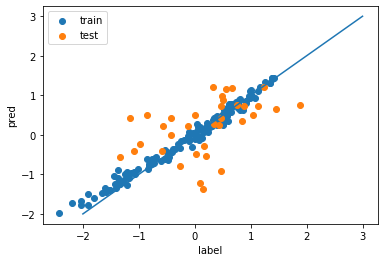

In [26]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_seqs = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 0, alpha = 0.0, eva_on='seqs')
gpr_train_seqs.regression()
gpr_train_seqs.scatter_plot()

## Repeated KFold

In [15]:
import pickle

with open('kflod_results/repeated_kfold_wd_shift_logTrue_evaSeq.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [16]:
import xarray
result_test_s0_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 0)].mean(axis = -1).mean(axis = -1)
result_test_s1_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 1)].mean(axis = -1).mean(axis = -1)
result_test_s2_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

In [17]:
result_test_s0_aveSplit_aveRepeat

<xarray.DataArray (alpha: 21, l: 4)>
array([[1.26233808, 1.21934278, 1.22246368, 1.10961882],
       [0.87459999, 0.87055171, 0.89713976, 0.85547907],
       [0.80702986, 0.83542606, 0.7892894 , 0.79315209],
       [0.79325253, 0.78738795, 0.77396435, 0.75315738],
       [0.7807854 , 0.79277263, 0.74850416, 0.74925239],
       [0.78557403, 0.76527113, 0.75953693, 0.74250648],
       [0.77974293, 0.7499474 , 0.75541773, 0.73589765],
       [0.76827697, 0.76355223, 0.75677268, 0.76297781],
       [0.77190605, 0.755155  , 0.74417191, 0.73820289],
       [0.76817021, 0.7678082 , 0.74778035, 0.7373879 ],
       [0.76324691, 0.76190945, 0.74107088, 0.73617823],
       [0.77021022, 0.75805215, 0.75020015, 0.75312134],
       [0.77042698, 0.76062137, 0.75078407, 0.74486233],
       [0.78048303, 0.75572055, 0.74794436, 0.74768476],
       [0.7685245 , 0.75632756, 0.74770342, 0.74510788],
       [0.76589546, 0.76415929, 0.74522604, 0.74827753],
       [0.77253683, 0.76538293, 0.74385624, 0.74639469],
       [0.77443947, 0.76357087, 0.7573345 , 0.74543478],
       [0.76844234, 0.7607419 , 0.74840374, 0.74997674],
       [0.77345261, 0.76044826, 0.75561943, 0.75037812],
       [0.76387207, 0.76333613, 0.75403397, 0.75108625]])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
  * l           (l) <U3 '[3]' '[4]' '[5]' '[6]'
    s           int64 0

In [18]:
result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s1_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s2_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]

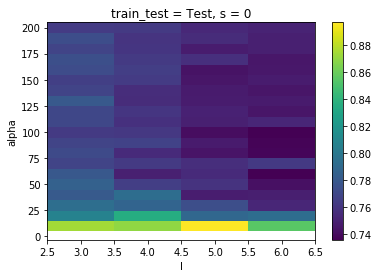

In [19]:
result_test_s0_aveSplit_aveRepeat.where(result_test_s0_aveSplit_aveRepeat < 1).plot()

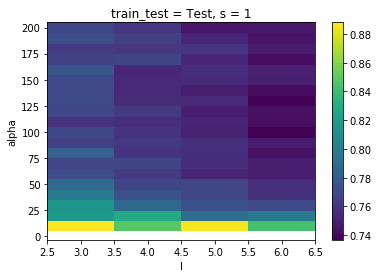

In [20]:
result_test_s1_aveSplit_aveRepeat.where(result_test_s1_aveSplit_aveRepeat < 1).plot()

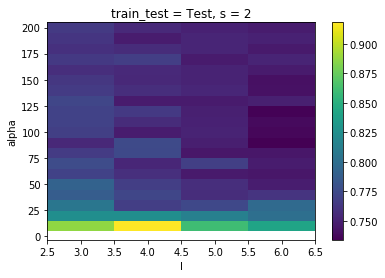

In [21]:
result_test_s2_aveSplit_aveRepeat.where(result_test_s2_aveSplit_aveRepeat < 1).plot()

In [22]:
# average mean square error for testing 

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (alpha: 21)>
array([1.1512797 , 0.84359855, 0.79909973, 0.77068351, 0.75755586,
       0.75657694, 0.74872428, 0.74963607, 0.74386427, 0.74837986,
       0.73680298, 0.74181425, 0.74306736, 0.73768472, 0.74125225,
       0.75029304, 0.75087085, 0.74175137, 0.74907985, 0.74476065,
       0.74683378])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1

In [23]:
# std of mean square error for testing

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).std(axis = -1)

<xarray.DataArray (alpha: 21)>
array([0.09969509, 0.02697518, 0.04492847, 0.02948356, 0.02706565,
       0.0233904 , 0.02620881, 0.02209315, 0.02025293, 0.01341702,
       0.01194087, 0.02283254, 0.01004528, 0.01353901, 0.01234023,
       0.01097683, 0.01417145, 0.01417162, 0.02050755, 0.00907089,
       0.00887418])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1